In [1]:
# Import my .py code 
# Run this to reimport without having to restart the whole notebook
import calibration_functions
import importlib
importlib.reload(calibration_functions)
from calibration_functions import *

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm as tqdm
import pandas as pd
from matplotlib import colors

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 10 
matplotlib.rcParams['figure.dpi'] = 300

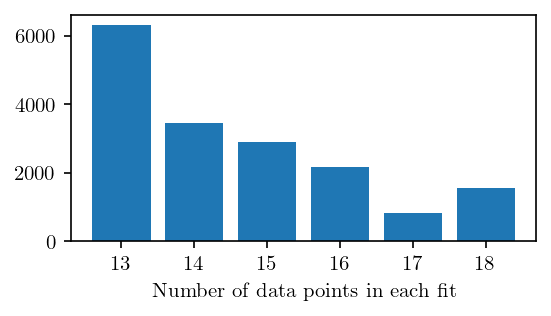

In [20]:
filename = r"expres_tp/LFC_200907.1063.fits"
hdu1 = fits.open(filename)
data = hdu1[1].data.copy()

size = []
chi2vals = []
probs = []
ndof = []
for order in np.arange(40, 85):
    data_spec       = data['spectrum'][order]
    data_spec_err       = data['uncertainty'][order]
    peak_locs = func_find_peaks(data_spec, 11, 0.15)[0]
    
    if len(peak_locs) < 10:
            continue
    
    peak_index_ranges = get_peak_index_ranges(peak_locs)

    for k in peak_index_ranges:
        size.append(k[1] - k[0])

    # # Fit peak in each data slice
    # peak_fits = fit_peaks(data_spec, data_spec_err, peak_index_ranges)

    # # Get chi2 and prop
    # chi2vals.append(peak_fits[:, 8])
    # probs.append(peak_fits[:, 13])
    # ndof.append(peak_fits[:, 9])

# Flatten
# chi2vals = np.concatenate(chi2vals)
# probs = np.concatenate(probs)
# ndof = np.concatenate(ndof)
size = np.asarray(size)

plt.figure(figsize=(4, 2))
# plt.hist(size, bins=13, range=(12, 19));
value = np.unique(size)
count = [len(size[size == s]) for s in value]
plt.bar(value,count)
plt.xlabel("Number of data points in each fit")
plt.xticks(value)

plt.savefig("N_data_points.pdf", bbox_inches="tight", dpi=300)

In [11]:
filename = r"expres_tp/LFC_200907.1063.fits"
hdu1 = fits.open(filename)
data = hdu1[1].data.copy()

def compute_chi2s(uncertainty_factor = 1):
    chi2vals = []
    probs = []
    ndof = []
    for order in tqdm.tqdm(np.arange(len(data))):
        data_spec       = data['spectrum'][order]
        data_spec_err   = data['uncertainty'][order] * uncertainty_factor
        
        # Find peaks
        peak_info = func_find_peaks(data_spec, 11, 0.15)
        peak_locs = peak_info[0]

        if len(peak_locs) < 10:
            continue

        # Create data slices around each peak
        peak_index_ranges = get_peak_index_ranges(peak_locs)

        # Fit peak in each data slice
        peak_fits = fit_peaks(data_spec, data_spec_err, peak_index_ranges)

        # Get chi2 and prop
        chi2vals.append(peak_fits[:, 8])
        probs.append(peak_fits[:, 13])
        ndof.append(peak_fits[:, 9])

    # Flatten
    chi2vals = np.concatenate(chi2vals)
    probs = np.concatenate(probs)
    ndof = np.concatenate(ndof)
    return chi2vals, probs, ndof

In [12]:
# # Let's try some other values

# results_1 = compute_chi2s()
# results_3 = compute_chi2s(np.sqrt(3))
# results_2 = compute_chi2s(np.sqrt(2))
# results_4 = compute_chi2s(np.sqrt(4))
# results_5 = compute_chi2s(np.sqrt(5))
# results_6 = compute_chi2s(np.sqrt(6))
# # results_7 = compute_chi2s(np.sqrt(7))
# # results_8 = compute_chi2s(np.sqrt(8))
# # results_9 = compute_chi2s(np.sqrt(9))
# results_10 = compute_chi2s(np.sqrt(10))

# results = [results_1, results_2, results_3, results_4, results_5, results_6]
# np.save("errors_factors", results)

  0%|          | 0/86 [00:00<?, ?it/s]/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:89: RuntimeWarning: overflow encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)
/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:89: RuntimeWarning: divide by zero encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)
100%|██████████| 86/86 [00:42<00:00,  2.01it/s]


In [3]:
results_1, results_2, results_3, results_4, results_5, results_6 = np.load("errors_factors.npy", allow_pickle=True)

In [15]:
np.histogram(results_1[0], range=(0, 100))[0]

(array([ 664, 2151, 2362, 2034, 1761, 1443, 1187, 1097,  871,  693]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]))

[26.] [8.4] [4.]


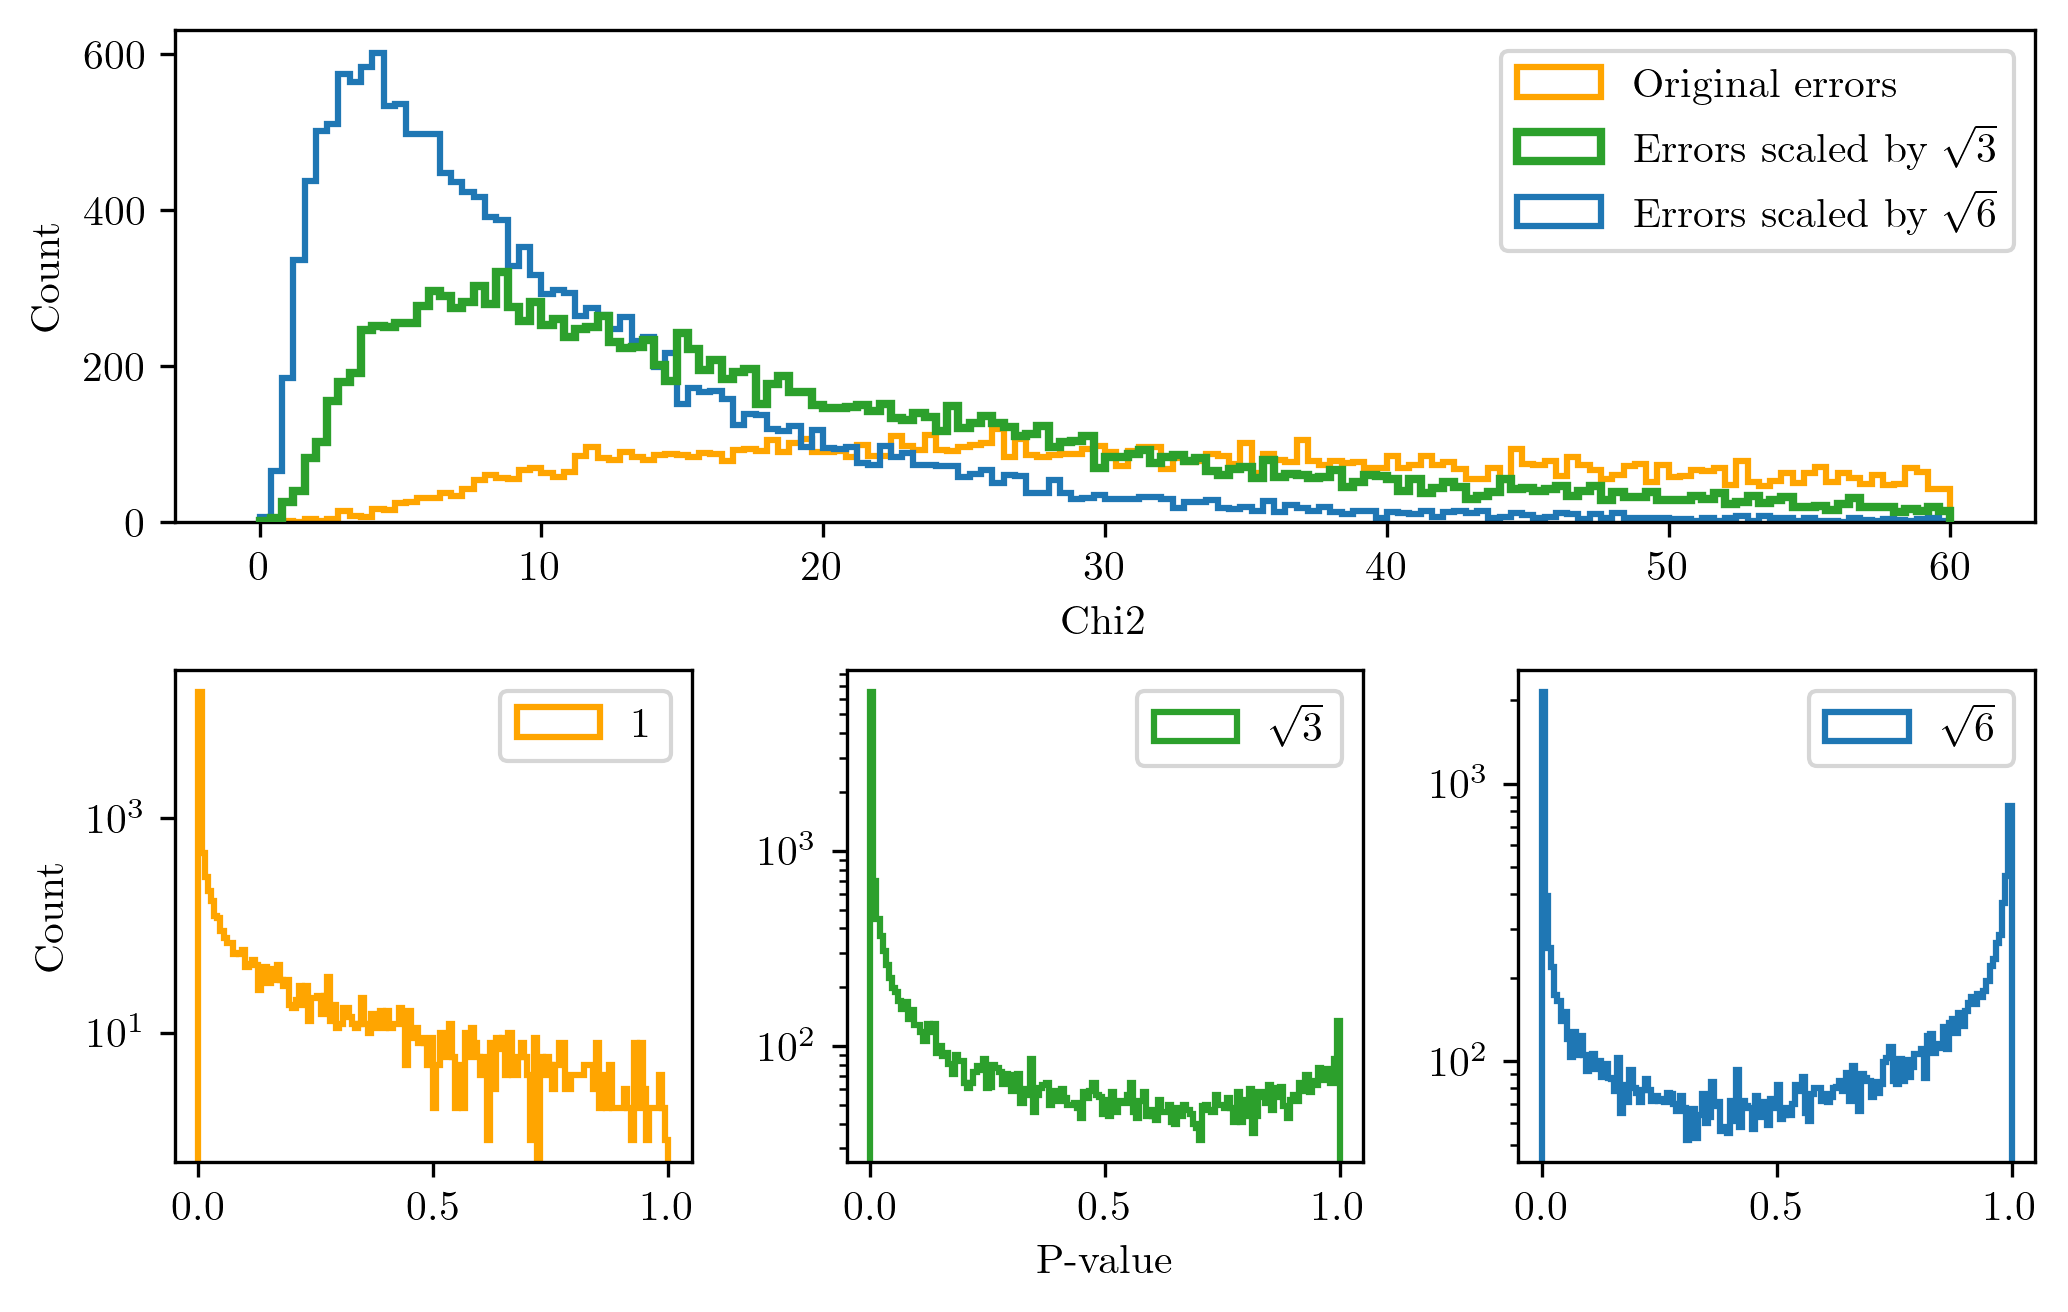

In [26]:
from matplotlib import colors
nbins = 150
range = (0, 60)

plt.figure(figsize = (7, 5))
grid = plt.GridSpec(2, 3, wspace=0.3, hspace=0.3)
ax1 = plt.subplot(grid[0, :3])  # wide top plot
ax2 = plt.subplot(grid[1, 0])   # |
ax3 = plt.subplot(grid[1, 1])   # | Three cols on the second row
ax4 = plt.subplot(grid[1, 2])   # |


# fig, ax1 = plt.subplots(figsize=(15,5))
y1, x1, _ = ax1.hist(results_1[0], bins=nbins, range=range, histtype="step", edgecolor="orange", lw=1.5, label="Original errors");
y3, x3, _ = ax1.hist(results_3[0], bins=nbins, range=range, histtype="step", edgecolor="C2", lw=2, label="Errors scaled by $\sqrt{3}$", zorder=100);
y6, x6, _ = ax1.hist(results_6[0], bins=nbins, range=range, histtype="step", edgecolor="C0", lw=1.5, label="Errors scaled by $\sqrt{6}$");
ax1.set_xlabel("Chi2")
ax1.set_ylabel("Count")
# ax1.set_ylabel("#")
ax1.legend(loc="upper right")

max_chi2_1 = x1[np.where(y1 == y1.max())]
max_chi2_3 = x3[np.where(y3 == y3.max())]
max_chi2_6 = x6[np.where(y6 == y6.max())]

print(max_chi2_1, max_chi2_3, max_chi2_6)

range = (0, 1)
ax2.hist(results_1[1], bins=nbins, range=range, histtype="step", edgecolor="orange", lw=1.5, label="$1$");
# ax2.set_ylabel("#")
ax2.legend(loc="upper right")
ax2.set_yscale("log")
ax2.set_ylabel("Count")

ax3.hist(results_3[1], bins=nbins, range=range, histtype="step", edgecolor="C2", lw=1.5, label="$\sqrt{3}$");
ax3.legend(loc="upper right")
ax3.set_xlabel("P-value")
ax3.set_yscale("log")

ax4.hist(results_6[1], bins=nbins, range=range, histtype="step", edgecolor="C0", lw=1.5, label="$\sqrt{6}$");
ax4.legend(loc="upper right")
ax4.set_yscale("log")

plt.savefig("latex/figures/calib/calib_errors2.pdf", bbox_inches='tight', dpi=300)

The chi2 values should be equal to the number of degrees of freedom in the fit. So we can see that the initial errors give a chi2 distribution that is waaay to flat. If we multiply by $\sqrt{3}$ we get something better. $\sqrt{10}$ looks perhaps even better! But, the p-value distribution should be flat (TODO: ask Troels why or look it up), so we can see that the original errors are probably too small and the ones multiplied by $\sqrt{10}$ are too high, because we get a spike at 1 — i.e. the fit is too good. The spike at 0 is okay, those are just all the fits that sucked and should perhaps be removed. 

Troels init suggestion to do this is here: https://mail.google.com/mail/u/0/?ui=2&view=btop&ver=ops2cvpehp6&cat=BSc&qid=99FD73A2-0ECF-4EF1-A8F9-58B18FCC72FD&search=cat&th=%23thread-f%3A1724470506419210702&cvid=1

He said: 

The Chi2 values are about a factor 3 too larger, thus the uncertainties are about a factor sqrt(3) too small. My evaluation is based on the notion, that the Prob-distribution should be about flat, when it is right (with peaks at the ends). We then seem to have a good fraction (10%?), which are poor fits, perhaps to be considered either for omission or increased uncertainty.



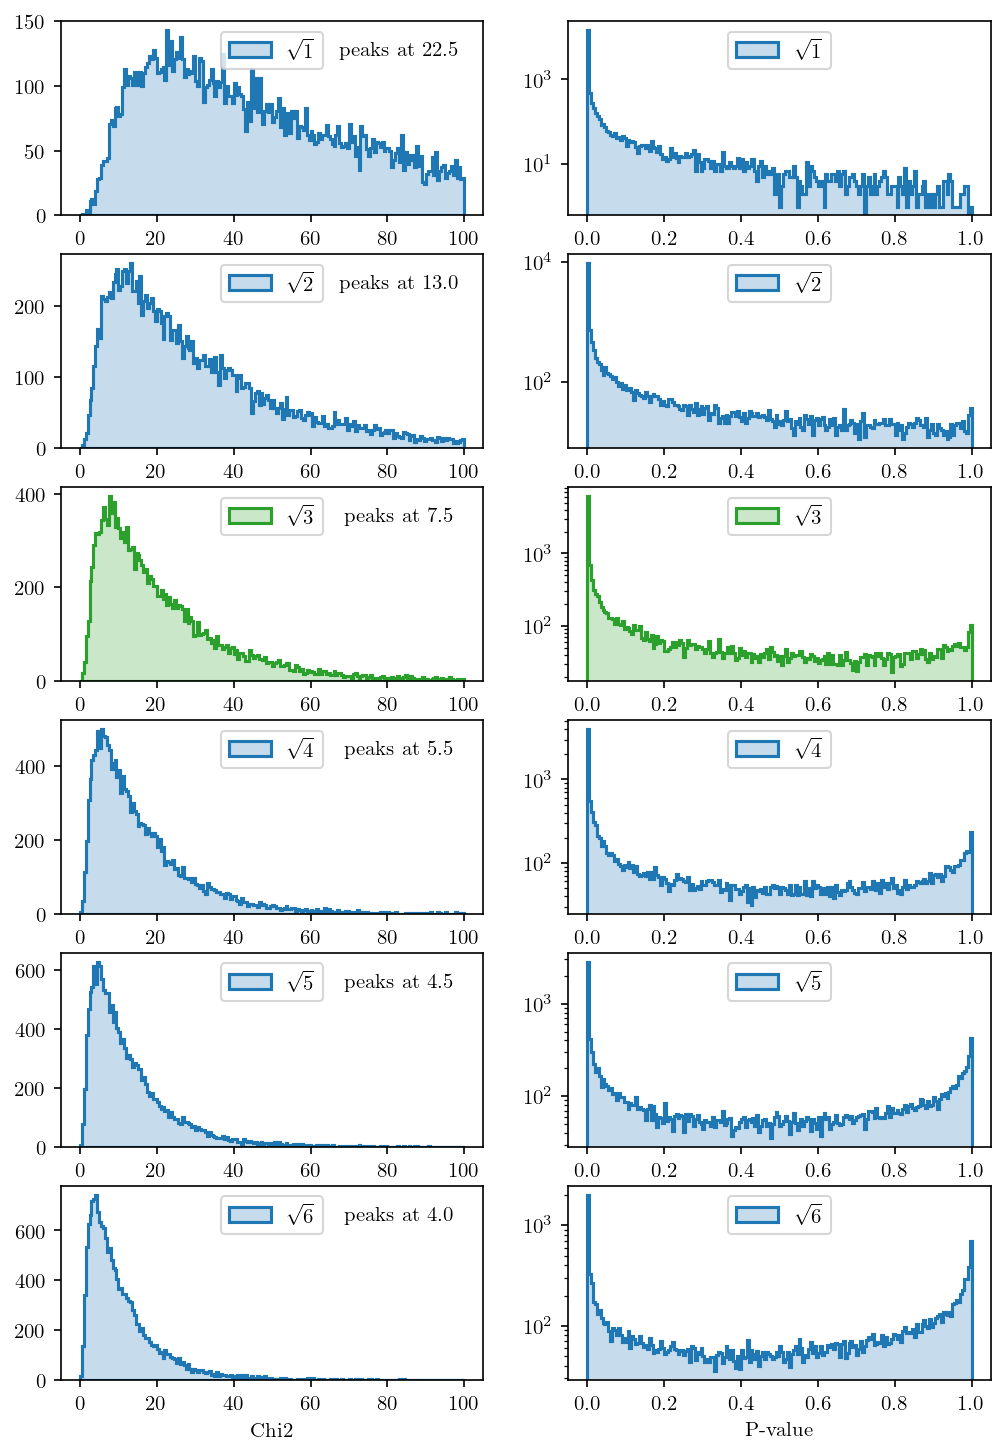

In [17]:

nbins = 200
chi2_range = (0, 100)
p_ranage = (0, 1)

fig, ax = plt.subplots(nrows = 6, ncols = 2, figsize=(8, 12))
results = np.load("errors_factors.npy")
factor = [1, 2, 3, 4, 5, 6]

for index, result in enumerate(results):
    s = "$\sqrt{" + str(factor[index]) + "}$"
    
    color = "C0"
    if factor[index] == 3:
        color = "C2"
    
    y, x, _ = ax[index, 0].hist(result[0], bins=nbins, range=chi2_range, histtype="stepfilled", facecolor=colors.to_rgba(color, 0.25), edgecolor=color, lw=1.5, label=s);
    max_chi2 = x[np.where(y == y.max())]
    ax[index, 0].text(0.8, 0.85, f"peaks at {max_chi2[0]}", horizontalalignment='center', verticalalignment='center', transform=ax[index, 0].transAxes)
    ax[index, 1].hist(result[1], bins=nbins, range=p_ranage, histtype="stepfilled", facecolor=colors.to_rgba(color, 0.25), edgecolor=color, lw=1.5, label=s);
    ax[index, 1].set_yscale("log")


# Set x labels for the last plots
last_row = factor[-1] - 1
ax[last_row, 0].set_xlabel("Chi2")
ax[last_row, 1].set_xlabel("P-value")

# Show legends on all plots
[x[0].legend(loc="upper center") for x in ax]
[x[1].legend(loc="upper center") for x in ax]

# fig.savefig("calib_errors_ext.pdf", bbox_inches='tight', dpi=300)


To have a good balance, where we can filter out the fits that give p ~ 0 and p ~ 1, perhaps sqrt(6) is better? TODO ask Troels. 